In [1]:
import numpy as np
from numpy import exp
from math import pi
from scipy import special as sp
from src import mie,vsh
from src.mie import compute_fields, em
#
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
wavelengths = [288., 375., 800.]
refr={
    'Si' : [4.1+5.4j,6.7+1.3j,3.7],
    'SiO2' : [1.5,1.5,1.5],
    #'Mo' : [3.1+4.4j, 3.5+3.5j, 3.7 + 3.6j]
}

In [3]:
k0 = 2*pi
nk = 51
t = np.linspace(0,pi,6)
#kx,ky = np.cos(t)*k0*0.9, np.sin(t)*k0*0.9
kx, ky = [1e-6+c.flatten() for c in np.meshgrid(np.linspace(-0.9*k0,0.9*k0, nk),np.linspace(-0.9*k0,0.9*k0, nk)) ]
k2 = kx**2 + ky**2
kx = kx[k2<k0**2]
ky = ky[k2<k0**2]
kz = np.sqrt(k0**2 - k2[k2<k0**2])
kvec = np.vstack((kx,ky,kz)).T
khatOUT = kvec / k0 


In [4]:
def dyadic_vectors(khatOUT, khatINC):
    """
    Polarization vectors for S-matrix dyad. 
    .. math:
        \mathbf{e}_{i,\perp} = \frac{\hat{\mathbf{k}}_i \times \hat{\mathbf{k}}}{|\hat{\mathbf{k}}_i \times \hat{\mathbf{k}}|}
        \mathbf{e}_{i,\par}  = \frac{\hat{\mathbf{e}}_{i,\perp} \times \hat{\mathbf{k}_i}}{|\hat{\mathbf{e}}_{i,\perp} \times \hat{\mathbf{k}_i}|}
        \mathbf{e}_{o,\perp} = \mathbf{e}_{i,\perp}
        \mathbf{e}_{o,\par}  = \frac{\hat{\mathbf{e}}_{o,\perp} \times \hat{\mathbf{k}}}{|\hat{\mathbf{e}}_{o,\perp} \times \hat{\mathbf{k}}|}
    """
    ki = khatINC.squeeze()
    ehati = []
    ehato = []
    for i, khat in enumerate(khatOUT):
        ei = np.cross(ki, khat)
        ei = [ei,np.cross(ei, ki)]
        
        eo = np.cross(ki, khat)
        eo = [eo,np.cross(eo, khat)]
        
        ei = [a.squeeze()/em.vecmag(a) for a in ei]
        eo = [a.squeeze()/em.vecmag(a) for a in eo]
        
        ehati += [ei]
        ehato += [eo]
        
    return np.array(ehato), np.array(ehati)
#
def far_field_dyadic(maxL, n, size_parameter, khatOUT, khatINC):
    eo, ei = dyadic_vectors(khatOUT, khatINC)
    S = np.zeros((len(khatOUT),4),dtype=np.complex)
    for i, khat in enumerate(khatOUT):
        Fper = mie.far_field_mie(maxL, n, size_parameter, khat[None,:], khatINC, ei[i][0][None,:]).squeeze()
        Fpar = mie.far_field_mie(maxL, n, size_parameter, khat[None,:], khatINC, ei[i][1][None,:]).squeeze()
        S[i] = [(eo[i,0]*Fper).sum(),(eo[i,1]*Fper).sum(),(eo[i,0]*Fpar).sum(),(eo[i,1]*Fpar).sum()]
    #
    return S

In [5]:
khatINC = np.array([[0.,0.,1.]])
ehatINC = np.array([[0.,1.,0.]])
#
eo, ei = dyadic_vectors(khatOUT, khatINC)
eo = np.array(eo)
ei = np.array(ei)
#
FF = dict([(key,[]) for key in refr.keys()])
a  = 288.0 # nm
for key, val in refr.items():
    for wavindx, wavelength in enumerate(wavelengths):
        print(key,val[wavindx], a/wavelength)
        S = far_field_dyadic(15, val[wavindx], a/wavelength, khatOUT, khatINC)
        FF[key] += [S]

Si (4.1+5.4j) 1.0
Si (6.7+1.3j) 0.768
Si 3.7 0.36
SiO2 1.5 1.0
SiO2 1.5 0.768
SiO2 1.5 0.36
Mo (3.1+4.4j) 1.0
Mo (3.5+3.5j) 0.768
Mo (3.7+3.6j) 0.36


In [6]:
def make_plot(func):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    for i,wav in enumerate(wavelengths):
        fig,axs=plt.subplots(dpi=100, figsize=(6,4), ncols=3)
        for j, (key, val) in enumerate(FF.items()):
            ax = axs[j]
            ax.set_title('$\lambda = ${:.0f}, {}'.format(wav, key))
            ax.set_aspect('equal')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            C1 = func(val[i])
            im=ax.scatter(khatOUT[:,0],khatOUT[:,1],c=C1, s=40, cmap='plasma')
            
            divider = make_axes_locatable(ax)
            #cax = divider.append_axes("right", size="5%", pad=0.05)
            
        fig.colorbar(im,ax=ax,fraction=0.03)
        fig.tight_layout()

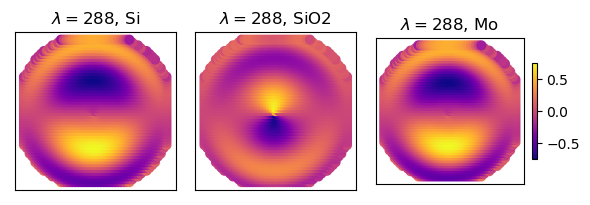

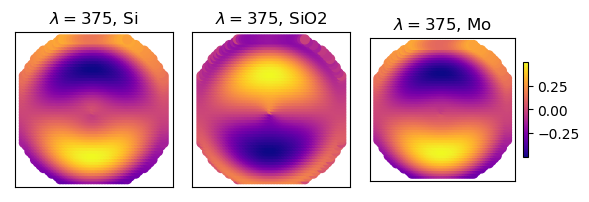

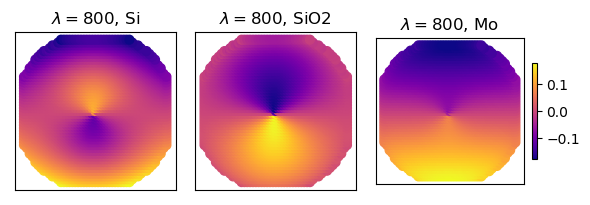

In [7]:
make_plot(lambda v : np.real(v[:,0]*eo[:,0,0]) )

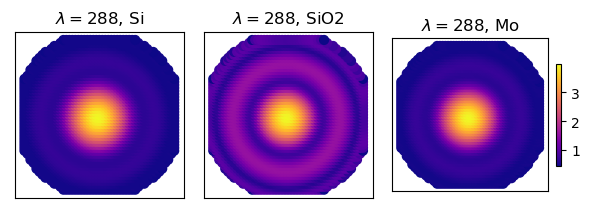

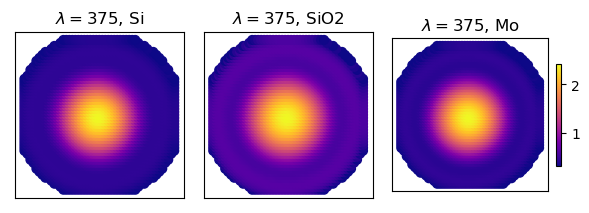

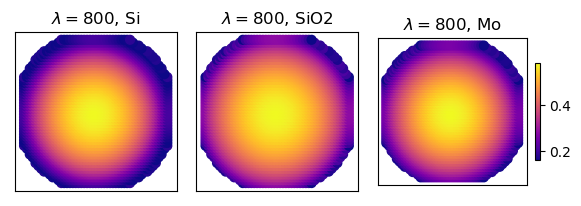

In [14]:
make_plot(lambda v : np.abs(v[:,0]) )

In [12]:
import pickle

In [13]:
pickle.dump((FF,refr,wavelengths),open('tmp/Smatrix_and_NearFields_3Spheres.pkl','wb'))